* Make sure before running the example that your execution path is in this example directory.
* (Use `!pwd` to check and `%cd` to adjust the path if needed)

In [179]:
# clean up all files from the previous run
!rm trajectory.dat
!rm energy.dat
!rm *.pyidx
!rm relax_energy.dat

rm: cannot remove 'trajectory.dat': No such file or directory


## Let's have a look at the initial conf.

In [180]:
# all functions required to read a configuration using the new RyeReader
from oxDNA_analysis_tools.UTILS.RyeReader import describe, get_confs, inbox
# the function used to visualize a configuration in oxView
from oxDNA_analysis_tools.UTILS.oxview import oxdna_conf

top = "./hairpin.top"
traj = "./hairpin.conf"
input_file = "./input"
# RyeReader uses indexing allows for random access in the trajectory
top_info, traj_info = describe(top, traj)

# This is the new way to read configurations, as it returns a list we need [0]
# to access a single conf
ref_conf = get_confs(traj_info.idxs, traj_info.path, 0, 1, top_info.nbases)[0]
# inbox the configuration
ref_conf = inbox(ref_conf)

# show an iframe displaying the configuration
# inbox_settings = ["None", "None"] makes sure oxview does no post processing of the
# loaded configuration
oxdna_conf(top_info, ref_conf, inbox_settings=["None","None"])

## Notes:
* We see that our system is a small unrelaxed hairpin.
## Next:
* Next we will run a short relaxation simulation.
* The simulation is run on a separate thread, so during the run it is possible to run the analysis cells down the book.
* This also potentially allows to run more than one replica at a time.

In [186]:
import oxpy
import multiprocessing
# constant defining the number of simulation steps we run
STEPS = 2000000
INTERVAL = 10000
dt = 0.003

# helper function offloading the work to a new process
def spawn(f, args = ()):
    p = multiprocessing.Process(target=f, args= args )
    p.start()
    return p

# one simulation instance
# if you want to have multiple make sure the output files are different
# resources used (like GPU's are different)  
def relax_replica():
    with oxpy.Context():
        input = oxpy.InputFile()
        input.init_from_filename("input")
        # all input parameters provided to oxDNA need to be strings 
        input["steps"] = str(STEPS)
        input["print_conf_interval"] = str(INTERVAL)
        input["print_energy_every"] = str(INTERVAL)
        input["dt"] = str(dt)
        # make sure our output is not overcrowded
        input["no_stdout_energy"] = "true"
        # these settings turn a regular simulation into a relaxation one  
        input["T"] = "10C"
        input["max_backbone_force"] = "5"
        input["max_backbone_force_far"] = "10"
        input["energy_file"] = "relax_energy.dat"
        # discard the relax data 
        input["trajectory"] = "/dev/null"


        # init the manager with the given input file
        manager = oxpy.OxpyManager(input)
        #run complete run's it till the number steps specified are reached 
        manager.run_complete()

#make sure we don't have anything running
try:
    p.terminate()
except:
    pass
# run a simulation and obtain a reference to the background process
p = spawn(relax_replica)


## Monitor the energy during the relaxation run.
* let's plot the energy 
* we run a MD relaxation simulation, so the file format is:
`[time (steps)] [Total Energy] [Potential Energy] [Kinetic Energy]`
* we'll use a red line to indicate complition
* as we are looking at a hairpin which we will melt in further steps a `good` relaxed energy would be around -1
    * note this is different from an origami relaxation where everything has to be paired and values around -1.45 are `good`.
* all following cells can be reloaded multiple times during the running simulation to see progress

Relaxation is running: False


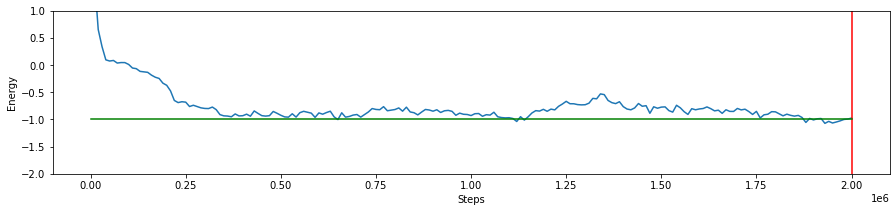

In [189]:
import pandas as pd
import matplotlib.pyplot as plt
df = pd.read_csv("relax_energy.dat", delimiter="\s+",names=['time', 'U','P','K'])

# make sure our figure is bigger
plt.figure(figsize=(15,3)) 
# plot the energy
plt.plot(df.time/dt,df.U)
# and the line indicating the complete run
plt.ylim([-2,1])
plt.plot([STEPS,STEPS],[df.U.max(),df.U.min()-2], color="r")
plt.ylabel("Energy")
plt.xlabel("Steps")
# and the relaxed state line
plt.plot([0,STEPS], [-1,-1], color="g")
print("Relaxation is running:", p.is_alive())


## Note:
* it is easy to implement a relaxation run which will terminate the process after a desired energy value is reached
* at any point in time we can interupt the run by calling `p.terminate()`

# Let's have a look on the relaxed last conf 

In [188]:
#load and inbox
ti, di = describe(top, "./last_conf.dat")
conf = inbox(get_confs(di.idxs, di.path, 0,1, ti.nbases)[0])
# display
oxdna_conf(ti, conf, inbox_settings=["None","None"])

## Now let's do a melting simulation
* we know that @ 60.85C the hairpin will transition between a fully bonded state and fully melted

In [273]:
STEPS = 60000000
INTERVAL = 50000
# define our boiler plate code to run the simulation
def replica():
    with oxpy.Context():
        input = oxpy.InputFile()
        input.init_from_filename("input")
        # all input parameters provided to oxDNA need to be strings 
        input["conf_file"] = "last_conf.dat"
        input["steps"] = str(STEPS)
        input["print_conf_interval"] = str(INTERVAL)
        input["print_energy_every"] = str(INTERVAL)
        input["dt"] = str(dt)
        # make sure our output is not overcrowded
        input["no_stdout_energy"] = "true"
        
        # init the manager with the given input file
        manager = oxpy.OxpyManager(input)
        #run complete run's it till the number steps specified are reached 
        manager.run_complete()

#make sure we don't have anything running
try:
    p.terminate()
except:
    pass
#note that for more than one replica running you will have to change the guard code 
spawn(replica)

<Process name='Process-69' pid=831693 parent=798105 started>

## we will monitor the run in almost the same way as before
* Energy ~ -1 corresponds to open structure blue line
* Energe ~ -1.2 is a fully bonded hairpin green line
* Total steps - red line
* the visualization is the last conf with computed bond energy per nucleotide

Simulation is running: False


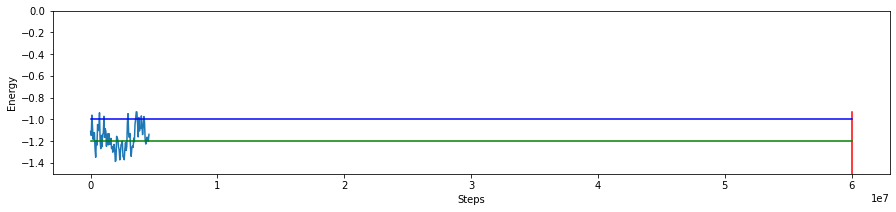

Last configuration is:
INFO: oxDNA_analysis_tools version: 2.0.1
INFO: running config.py installed at:  /home/micha/.local/lib/python3.9/site-packages/oxDNA_analysis_tools/config.py
INFO: Python version: 3.9.7
INFO: Package Numpy found. Version: 1.22.4
INFO: No dependency issues found.
INFO: no units specified, assuming oxDNA su
INFO: Processing in blocks of 20 configurations
INFO: You can modify this number by running oat config -n <number>, which will be persistent between analyses.
Starting up 2 processes for 1 chunks
All spawned, waiting for results
INFO: The generator will try to take into account bonded interactions by choosing distances between bonded neighbours no larger than 2.000000
INFO: Converting temperature from Celsius (60.850000 C°) to simulation units (0.111333)
INFO: Running Debye-Huckel at salt concentration =  1
INFO: Using different widths for major and minor grooves
DEBUG: Debye-Huckel parameters: Q=0.054300, lambda_0=0.361646, lambda=0.381589, r_high=1.144767, cu

In [276]:
import pandas as pd
import matplotlib.pyplot as plt
df = pd.read_csv("energy.dat", delimiter="\s+",names=['time', 'U','P','K'])

# make sure our figure is bigger
plt.figure(figsize=(15,3)) 
# plot the energy
plt.plot(df.time/dt,df.U)
# and the line indicating the complete run
plt.ylim([-1.5,0])
plt.plot([STEPS,STEPS],[df.U.max(),df.U.min()-2], color="r")
plt.ylabel("Energy")
plt.xlabel("Steps")
# and the relaxed state line
plt.plot([0,STEPS], [-1,-1], color="b")
plt.plot([0,STEPS], [-1.2,-1.2], color="g")
print("Simulation is running:", p.is_alive())
plt.show()


#load last conf
ti, di = describe(top, "./last_conf.dat")
conf = get_confs(di.idxs, di.path, 0,1, ti.nbases)[0]
print("Last configuration is:")

#produce the hydrogen bond overlay
!oat output_bonds -v bonds -p 2 input last_conf.dat

from json import loads
with open("bonds_Total.json") as file:
    overlay = loads(file.read())

# display
oxdna_conf(ti, conf, overlay=overlay)